    Area Health Resources File

Imports and Variables

In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.colors as colors
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.express as px

from module.variables import *
from module.functions import *

import pickle


Load Data and Functions

In [2]:
# USA Provider Information for Each State
yr_21 = pd.read_csv("Providers/AHRFDashboard_20-21.csv", skiprows = 2).drop("Source", axis = 1).rename(columns={"State/Territory":"NAME", "M.D., Ophthalmology (County Level File)":"Ophthalmologists_21", "Population, All (County Level File)":"Pop_21", "Rate (per 100,000 population)":"Rate_100k_21_Ophtho"}).loc[0:53, :]
yr_20 = pd.read_csv("Providers/AHRFDashboard_19_20.csv", skiprows = 2).drop("Source", axis = 1).rename(columns={"State/Territory":"NAME", "M.D., Ophthalmology (County Level File)":"Ophthalmologists_20", "Population, All (County Level File)":"Pop_20", "Rate (per 100,000 population)":"Rate_100k_20_Ophtho"}).loc[0:53, :]
yr_19 = pd.read_csv("Providers/AHRFDashboard_18_19.csv", skiprows = 2).drop("Source", axis = 1).rename(columns={"State/Territory":"NAME", "M.D., Ophthalmology (County Level File)":"Ophthalmologists_19", "Population, All (County Level File)":"Pop_19", "Rate (per 100,000 population)":"Rate_100k_19_Ophtho"}).loc[0:53, :]

#All MDs for the USA
all_providers = pd.read_csv('all_md.csv')
for index, row in all_providers.iterrows():
    pop = int("".join([x for x in row["Pop_22"] if x != ","]))
    MD = float("".join([x for x in row["MD_22"] if x != ","]))
    all_providers.loc[index,"Pop_22"] = pop
    all_providers.loc[index,"MD_22"] = MD
all_providers["Pop_22"] = all_providers["Pop_22"].astype(float)
all_providers["MD_22"] = all_providers["MD_22"].astype(float)

#Ophthalmology residents in the USA by state
residents = pd.read_csv("Residency.csv", header = None)

In [3]:
with open('specialty_state_positions.pickle', 'rb') as handle:
    residency_state = pickle.load(handle)


residents_all = pd.DataFrame(0 ,columns= list(residency_state.keys()) + ["All"], index=state_salaries)
for s in residency_state:
    for state in residency_state[s]:
        if state in state_salaries:
            residents_all.loc[state,"All"] +=  residency_state[s][state]
            residents_all.loc[state,s] =  residency_state[s][state]

residents_ophtho_all = residents_all.loc[:, ["Ophthalmology", "All"]]
residents_ophtho_all.reset_index(inplace=True)
residents_ophtho_all = residents_ophtho_all.rename(columns = {'index':'STUSPS'})
residents_ophtho_all = residents_ophtho_all.rename(columns = {'Ophthalmology':'Ophtho_Residents'})

In [4]:
#Formats the resident data for USA ophtho
residents.columns = ["NAME"]
residents["Ophtho_Residents"] = 0

for x in residents["NAME"]:
    y = x.split(" ")
    if len(y) == 3:
        state = y[0] + " " + y[1]
    else:
        state = y[0]
    number = y[-1]
    number = int(number[1:-1])
    residents.loc[residents["NAME"] == x, "Ophtho_Residents"] = number
    residents.loc[residents["NAME"] == x, "NAME"] = state

In [5]:
#Create DataFrames for Salaries for Each State
salaries_df = pd.DataFrame([state_salaries, salaries]).T
salaries_df.columns = ["STUSPS", "Salaries"]

In [6]:
'''#Parse 2020 ophthalmology Data for EU
labels = 'AT 0,80 BE 0,88 BG 1,03 HR 0,95 CY 1,40 CZ 0,99 DK 0,50 EE 1,21 FI 0,89 FR 0,88 DE 0,49 GR 2,80 HU 1,02 IE 0,69 IT 1,26 LV 1,14 LT 1,23 NL 0,38 MK 0,14 NO 1,04 PO 1,24 RO 1,28 RS 0,93 SI 0,71 ES 0,89 SE 0,79 CH 1,38 TR 0,44 UK 0,22'
labels = labels.split(" ")
counteries = [labels[x] for x in range(0, len(labels), 2) ]
per_10k = [labels[x].replace(",", ".") for x in range(1, len(labels), 2) ]

EU = pd.DataFrame(columns=["Country","per_10k"])

for x in range(len(counteries)):
    country = l2c[counteries[x]]
    temp = pd.DataFrame(data=[[country, per_10k[x]]], columns=["Country", "per_10k"])
    EU = pd.concat([EU, temp])

EU = EU.merge(EU_pop, on="Country")

EU["per_10k"] = EU["per_10k"].astype(float)
EU["Population"] = EU["Population"].astype(int)
EU["Ophthalmologists"] = EU["per_10k"]*EU["Population"]/10000
EU["Rate_100k"] = EU["per_10k"]*10
EU["Ophthalmologists"] = EU["Ophthalmologists"].apply(np.floor).astype(int)
EU = EU.drop("per_10k", axis=1)

EU'''

'#Parse 2020 ophthalmology Data for EU\nlabels = \'AT 0,80 BE 0,88 BG 1,03 HR 0,95 CY 1,40 CZ 0,99 DK 0,50 EE 1,21 FI 0,89 FR 0,88 DE 0,49 GR 2,80 HU 1,02 IE 0,69 IT 1,26 LV 1,14 LT 1,23 NL 0,38 MK 0,14 NO 1,04 PO 1,24 RO 1,28 RS 0,93 SI 0,71 ES 0,89 SE 0,79 CH 1,38 TR 0,44 UK 0,22\'\nlabels = labels.split(" ")\ncounteries = [labels[x] for x in range(0, len(labels), 2) ]\nper_10k = [labels[x].replace(",", ".") for x in range(1, len(labels), 2) ]\n\nEU = pd.DataFrame(columns=["Country","per_10k"])\n\nfor x in range(len(counteries)):\n    country = l2c[counteries[x]]\n    temp = pd.DataFrame(data=[[country, per_10k[x]]], columns=["Country", "per_10k"])\n    EU = pd.concat([EU, temp])\n\nEU = EU.merge(EU_pop, on="Country")\n\nEU["per_10k"] = EU["per_10k"].astype(float)\nEU["Population"] = EU["Population"].astype(int)\nEU["Ophthalmologists"] = EU["per_10k"]*EU["Population"]/10000\nEU["Rate_100k"] = EU["per_10k"]*10\nEU["Ophthalmologists"] = EU["Ophthalmologists"].apply(np.floor).astype(int

Structure Data

In [7]:
#Pull all salary data and interest level data for the states of interest
state_to_state = pull_all(10, [2020, 2021], state_salaries, "COVID").mean()
state_to_state = pd.DataFrame(state_to_state, columns = ["Interest_21"])
state_to_state["Interest_20"] = pull_all(10, [2019, 2020], state_salaries, "COVID").mean()
state_to_state["Interest_19"] = pull_all(10, [2018, 2019], state_salaries, "COVID").mean()
state_to_state["STUSPS"] = state_to_state.index
state_to_state = state_to_state.merge(salaries_df, on="STUSPS")
state_to_state["Salaries"] = state_to_state["Salaries"].astype('float')

In [8]:
#Combine it with provider level information and geography plots
states = geopandas.read_file('data/usa-states-census-2014.shp')
states = states.drop_duplicates()
states = states.merge(state_to_state, on="STUSPS")
states = states.merge(yr_21, on="NAME")
states = states.merge(yr_20, on="NAME")
states = states.merge(yr_19, on="NAME")
states = states.merge(all_providers, on="NAME")
states = states.merge(residents_ophtho_all, on="STUSPS", how='left')
states['Ophtho_Residents'] = states['Ophtho_Residents'].fillna(0)
states = states.sort_values(by=['NAME'])
states


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,...,Pop_20,Rate_100k_20_Ophtho,Ophthalmologists_19,Pop_19,Rate_100k_19_Ophtho,Pop_22,MD_22,Rate_100k_22_All,Ophtho_Residents,All
41,01,01779775,0400000US01,01,AL,Alabama,00,131172403111,4594951242,Southeast,...,4903185.0,4.63,228.0,4887871.0,4.66,4903185.0,10983.0,224.0,5,482
19,04,01779777,0400000US04,04,AZ,Arizona,00,294205282243,1027790845,Southwest,...,7278717.0,4.23,295.0,7171646.0,4.11,7278717.0,18343.0,252.0,4,567
20,05,00068085,0400000US05,05,AR,Arkansas,00,134771603434,2960200961,Southeast,...,3017804.0,3.91,127.0,3013825.0,4.21,3017804.0,6500.0,215.4,4,329
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,...,39512223.0,6.13,2417.0,39557045.0,6.11,39512223.0,113718.0,287.8,48,3666
21,08,01779779,0400000US08,08,CO,Colorado,00,268426928342,1176085119,West,...,5758736.0,4.97,278.0,5695564.0,4.88,5758736.0,16956.0,294.4,6,407
23,09,01779780,0400000US09,09,CT,Connecticut,00,12542396439,1814978794,Northeast,...,3565287.0,7.94,289.0,3572665.0,8.09,3565287.0,12977.0,364.0,5,618
39,10,01779781,0400000US10,10,DE,Delaware,00,5047093738,1398754502,Northeast,...,973764.0,4.21,45.0,967171.0,4.65,973764.0,2850.0,292.7,0,132
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,...,705749.0,13.32,97.0,702455.0,13.81,705749.0,6147.0,871.0,13,412
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,...,21477737.0,6.06,1289.0,21299325.0,6.05,21477737.0,58822.0,273.9,23,2266
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,...,10617423.0,4.38,446.0,10519475.0,4.24,10617423.0,25072.0,236.1,9,911


In [38]:
#Create Meatcolumns for values of interest
states["Need_21"] = states["Interest_21"]/states["Rate_100k_21_Ophtho"]
states["Need_20"] = states["Interest_20"]/states["Rate_100k_20_Ophtho"]
states["Need_19"] = states["Interest_19"]/states["Rate_100k_19_Ophtho"]
states["Rate_100k_dif_21_19"] = (states["Rate_100k_21_Ophtho"] - states["Rate_100k_19_Ophtho"])/states["Rate_100k_19_Ophtho"]*100
states["Need_Salaries"] = states["Salaries"]/states["Interest_21"]
states["Provider_Ratio_Optho"] = states["Ophthalmologists_21"]/states["Ophtho_Residents"]
states["Provider_Ratio_All"] = states["MD_22"]/states["All"]
states['Salaries_Region'] = states.groupby(['region'])['Salaries'].transform('mean')
states['Need_21_Region'] = states.groupby(['region'])['Need_21'].transform('mean')
states['Need_20_Region'] = states.groupby(['region'])['Need_20'].transform('mean')
states['Need_19_Region'] = states.groupby(['region'])['Need_19'].transform('mean')
states['Provider_Ratio_Optho_Region'] = states.groupby(['region'])['Provider_Ratio_Optho'].transform('mean')
states['Provider_Ratio_All_Region'] = states.groupby(['region'])['Provider_Ratio_All'].transform('mean')
states['Ophtho_Residents_Region'] = states.groupby(['region'])['Ophtho_Residents'].transform('mean')
states['Interest_21_Region'] = states.groupby(['region'])['Interest_21'].transform('mean')
states['Interest_20_Region'] = states.groupby(['region'])['Interest_20'].transform('mean')
states['Interest_19_Region'] = states.groupby(['region'])['Interest_19'].transform('mean')
states['Rate_100k_21_Ophtho_Region'] = states.groupby(['region'])['Rate_100k_21_Ophtho'].transform('mean')
states['Rate_100k_20_Ophtho_Region'] = states.groupby(['region'])['Rate_100k_20_Ophtho'].transform('mean')
states['Rate_100k_19_Ophtho_Region'] = states.groupby(['region'])['Rate_100k_19_Ophtho'].transform('mean')
states['Rate_100k_dif_21_19_Region'] = states.groupby(['region'])['Rate_100k_dif_21_19'].transform('mean')
states['Need_Salaries_Region'] = states.groupby(['region'])['Need_Salaries'].transform('mean')
states['Ophthalmologists_21_Region'] = states.groupby(['region'])['Ophthalmologists_21'].transform('mean')
# states.sort_values(by=["Need_21_Region"])

In [10]:
states["Pop_per_Resident"] = states["Pop_21"]/states["Ophtho_Residents"]
states["new"] = states["NAME"]
states = states.sort_values(by="Pop_per_Resident", ascending = False)
# states[["NAME", "Pop_per_Resident"], :]

In [11]:
# Merge to regional level information
regions = states.dissolve(by='region')

Plots

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
# fig, ax = plt.subplots(ncols=2)
cmap = plt.get_cmap('PuBu')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
# ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
# ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()

c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


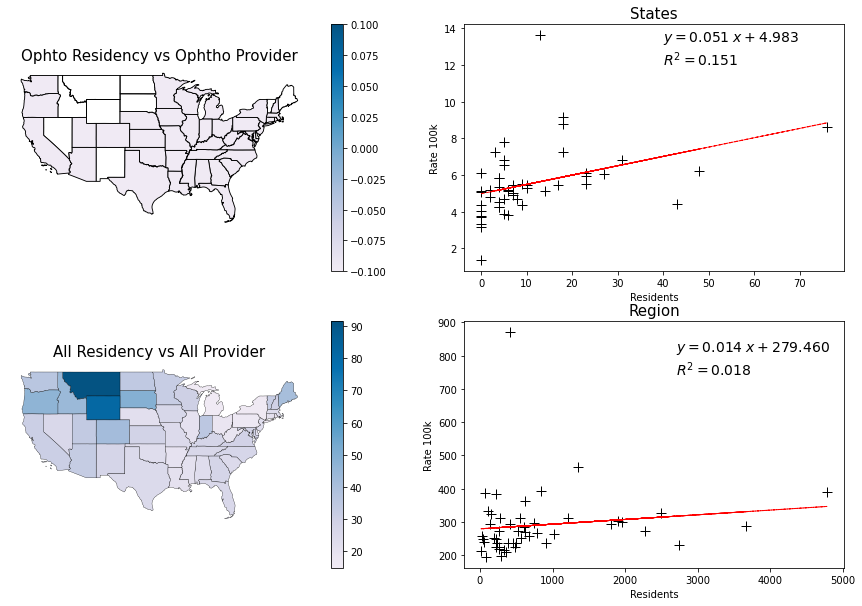

In [13]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Provider_Ratio_Optho", "Ophtho_Residents", "Rate_100k_21_Ophtho", new_cmap, 'Ophto Residency vs Ophtho Provider', 'Residents', 'Rate 100k', 40, 12, 2700, 850, region_map="Provider_Ratio_All", region_x = "All", region_y="Rate_100k_22_All", region_title='All Residency vs All Provider')

c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
c:\Users\aidan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


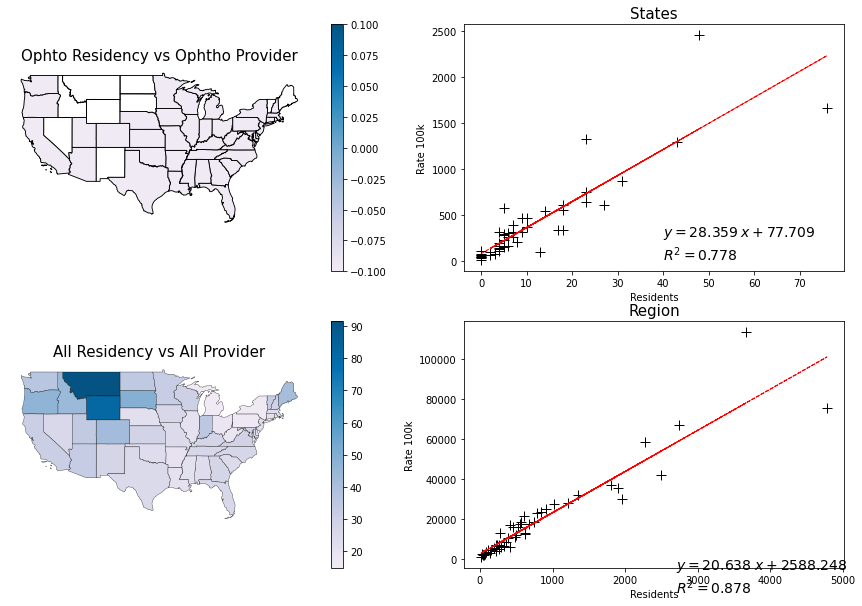

In [14]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Provider_Ratio_Optho", "Ophtho_Residents", "Ophthalmologists_21", new_cmap, 'Ophto Residency vs Ophtho Provider', 'Residents', 'Rate 100k', 40, 12, 2700, 850, region_map="Provider_Ratio_All", region_x = "All", region_y="MD_22", region_title='All Residency vs All Provider')

In [27]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# arr = np.linspace(0, 50, 100).reshape((10, 10))
# fig, ax = plt.subplots(ncols=2)
# cmap = plt.get_cmap('PuBu')
cmap = plt.get_cmap('seismic')
new_cmap = truncate_colormap(cmap, 0.7, 0)
# ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
# ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()

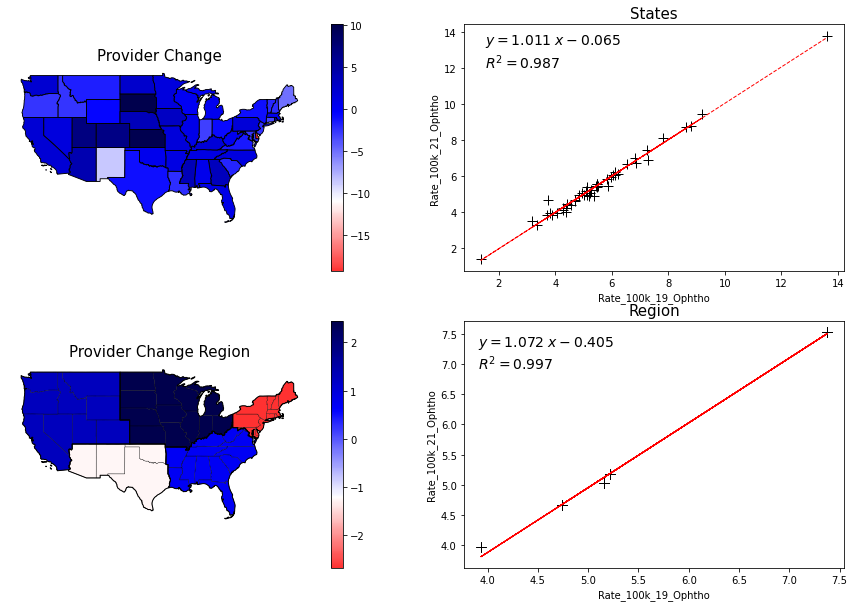

In [39]:
fig, ((ax1, ax3), (ax2, ax4)) = plot_us(states, regions, "Rate_100k_dif_21_19", "Rate_100k_21_Ophtho", "Rate_100k_19_Ophtho", new_cmap, 'Provider Change', 'Rate_100k_19_Ophtho', 'Rate_100k_21_Ophtho', 1.5, 12, 3.9, 7.5)

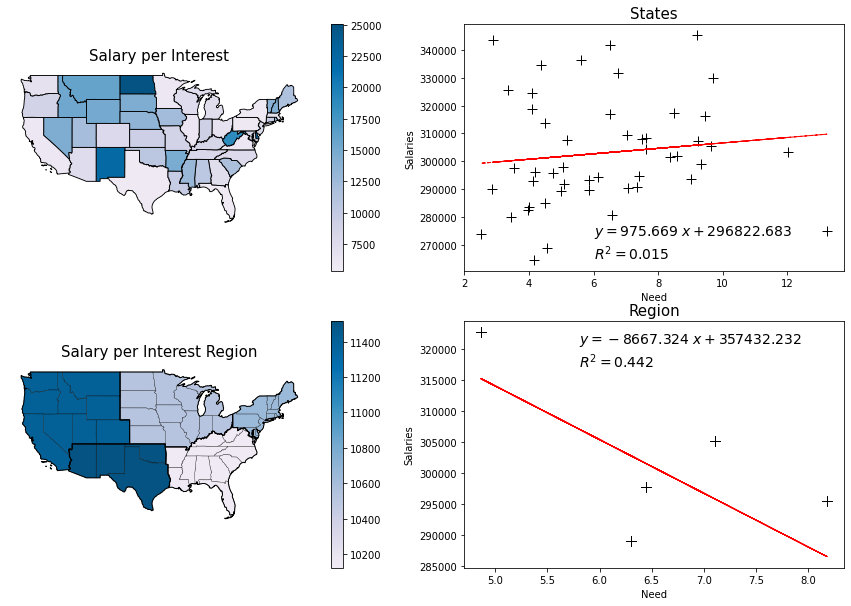

In [15]:
fig = plot_us(states, regions, "Need_Salaries", "Need_21", "Salaries", new_cmap, 'Salary per Interest', 'Need', 'Salaries', 6, 265000, 5.8, 323000)

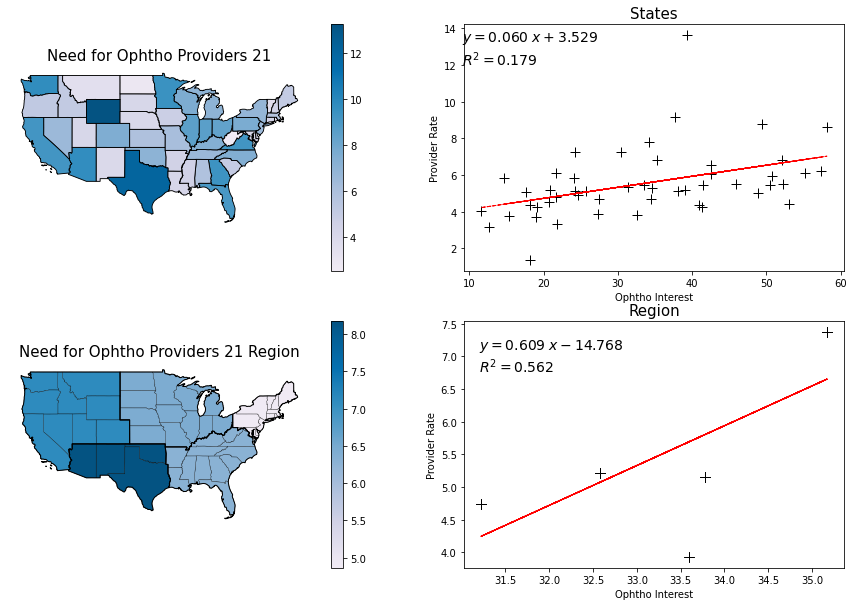

In [16]:
fig = plot_us(states, regions, "Need_21", "Interest_21", "Rate_100k_21_Ophtho", new_cmap, 'Need for Ophtho Providers 21', 'Ophtho Interest', 'Provider Rate', 9, 12, 31.2, 7.3)

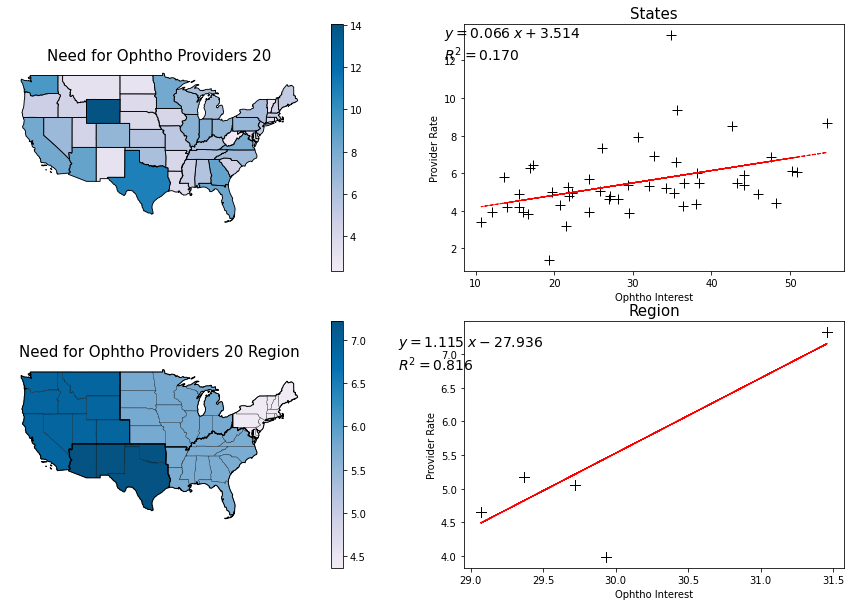

In [17]:
fig = plot_us(states, regions, "Need_20", "Interest_20", "Rate_100k_20_Ophtho", new_cmap, 'Need for Ophtho Providers 20', 'Ophtho Interest', 'Provider Rate', 6, 12, 28.5, 7.3)

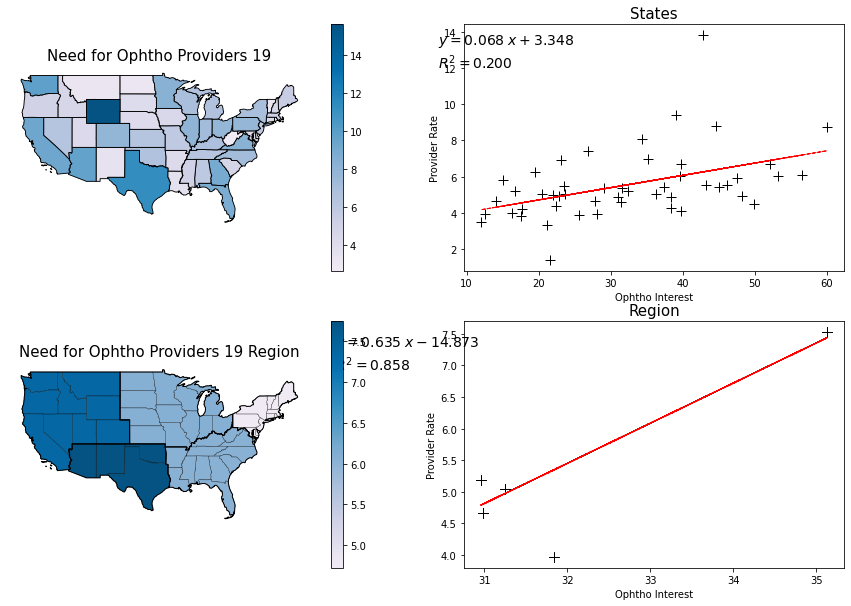

In [18]:
fig = plot_us(states, regions, "Need_19", "Interest_19", "Rate_100k_19_Ophtho", new_cmap, 'Need for Ophtho Providers 19', 'Ophtho Interest', 'Provider Rate', 6, 12, 29.2, 7.5)

PLOTLY Graphs

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [20]:
# fig = px.choropleth(states, geojson=states.geometry, 
#                     locationmode = 'USA-states',
#                     locations=states.STUSPS, 
#                     color="Need_19",
#                     height=500,
#                     hover_name = states.NAME,
#                     hover_data = [states.Interest_19, states.Rate_100k_19_Ophtho],
#                    color_continuous_scale="Viridis")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(
#     title_text='2019'
# )
# fig.update(layout = dict(title=dict(x=0.5)))
# fig.update_layout(
#     margin={"r":0,"t":30,"l":10,"b":10},
#     coloraxis_colorbar={
#         'title':'Sum'})
# fig.show()

# fig2 = px.choropleth(states, geojson=states.geometry, 
#                     locationmode = 'USA-states',
#                     locations=states.STUSPS, 
#                     color="Need_20",
#                     height=500,
#                     hover_name = states.NAME,
#                     hover_data = [states.Interest_20, states.Rate_100k_20_Ophtho],
#                    color_continuous_scale="Viridis")
# fig2.update_geos(fitbounds="locations", visible=False)
# fig2.update_layout(
#     title_text='2020'
# )
# fig2.update(layout = dict(title=dict(x=0.5)))
# fig2.update_layout(
#     margin={"r":0,"t":30,"l":10,"b":10},
#     coloraxis_colorbar={
#         'title':'Sum'})
# fig2.show()

# fig3 = px.choropleth(states, geojson=states.geometry, 
#                     locationmode = 'USA-states',
#                     locations=states.STUSPS, 
#                     color="Need_21",
#                     height=500,
#                     hover_name = states.NAME,
#                     hover_data = [states.Interest_21, states.Rate_100k_21_Ophtho],
#                    color_continuous_scale="Viridis")
# fig3.update_geos(fitbounds="locations", visible=False)
# fig3.update_layout(
#     title_text='2021'
# )
# fig3.update(layout = dict(title=dict(x=0.5)))
# fig3.update_layout(
#     margin={"r":0,"t":30,"l":10,"b":10},
#     coloraxis_colorbar={
#         'title':'Sum'})
# fig3.show()

In [21]:
fig1 = px.scatter(states, title = "2019", x="Interest_19",y="Rate_100k_19_Ophtho", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig1.show()
fig1.write_html('Figures/2019.html')
fig2 = px.scatter(states, title = "2020", x="Interest_20",y="Rate_100k_20_Ophtho", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig2.show()
fig2.write_html('Figures/2020.html')
fig3 = px.scatter(states, title = "2021", x="Interest_21",y="Rate_100k_21_Ophtho", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig3.show()
fig3.write_html('Figures/2021.html')
fig4 = px.scatter(states, title = "Ophtho_Residents", x="Ophtho_Residents",y="Ophthalmologists_21", color="region", trendline="ols", trendline_scope="overall", hover_data=["NAME"])
fig4.show()
fig4.write_html('Figures/Residents.html')
